In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score

/Users/clarencestudy/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read in the csv file as a pandas dataframe
df = pd.read_csv("customer_behavior_prediction_dataframe.csv")
"""
There are 2 features that serve more like categorical feature 
dropping them is not going to signficantly increase the accuracy
"""
# df = df.drop(columns = ["has_image", "has_emoji"]) 
df

,review_length,number_of_keywords,word_diversity,word_complexity,has_image,has_emoji,timing,count_helpful,creativity
0,279,145,60.161175,7.7,0,0,633,3,72.495699
1,85,37,62.242682,7.5,1,0,666,0,66.882998
2,101,46,46.116319,11.4,0,0,652,2,70.648072
3,52,25,84.124444,11.3,0,0,672,0,52.908236
4,66,34,66.000000,5.4,0,0,659,0,68.367608
...,...,...,...,...,...,...,...,...,...
1321,7,5,0.000000,2.3,0,0,391,0,NaN
1322,68,38,76.160000,4.0,1,0,96,36,68.169552
1323,5,5,7.000000,11.2,0,0,394,0,NaN
1324,43,23,43.000000,7.3,0,0,207,1,64.520857


In [3]:
# Check if there is any NaN, only our target variable has some NA values. This is caused by the fact that 
# we are using the key word list to calculat the divergent thinking score. There is a chance that there is 
# only one keyword, which gives an empty result. 
df.isna().any()

review_length         False
number_of_keywords    False
word_diversity        False
word_complexity       False
has_image             False
has_emoji             False
timing                False
count_helpful         False
creativity             True
dtype: bool

In [4]:
# Have around 1000 valid data 
nan_count = df["creativity"].isna().sum()
print(f"The number of NaN value in the target feature is {nan_count}")
print(f"It takes about this proportion: {nan_count/df.shape[0]}")

The number of NaN value in the target feature is 388
It takes about this proportion: 0.29260935143288086


<font size="10">Show distribution of some features </font>

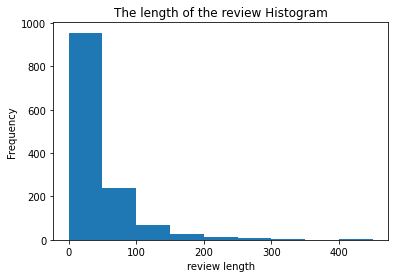

In [5]:
plt.hist(df["review_length"], bins=np.arange(0,500,50))
plt.gca().set(title='The length of the review Histogram', xlabel="review length", ylabel='Frequency')
plt.show()

<font size = "10">Data Preprocessing and Cleaning Step</font>
1. How to deal with missing value: 
    1. Remove rows that do not have a ground truth creativity 
    2. Replace with mean 
    3. Replace with min-value - standard deviation
2. Train test split for the 3 different versions of data
3. Scaling 
    1. Standard Scaler 
    2. Min Max Scaler
4. Add a column of ones 

In [6]:
# remove rows that have NA value 
df_no_NA = df.dropna()
df_no_NA

,review_length,number_of_keywords,word_diversity,word_complexity,has_image,has_emoji,timing,count_helpful,creativity
0,279,145,60.161175,7.7,0,0,633,3,72.495699
1,85,37,62.242682,7.5,1,0,666,0,66.882998
2,101,46,46.116319,11.4,0,0,652,2,70.648072
3,52,25,84.124444,11.3,0,0,672,0,52.908236
4,66,34,66.000000,5.4,0,0,659,0,68.367608
...,...,...,...,...,...,...,...,...,...
1318,135,70,66.010554,7.6,0,0,162,7,55.252269
1319,13,11,15.773333,8.6,0,0,376,0,74.619481
1320,23,12,37.030000,4.3,0,0,179,0,68.841466
1322,68,38,76.160000,4.0,1,0,96,36,68.169552


In [7]:
df_replaced_with_mean = df.copy() 
df_replaced_with_mean["creativity"] = df_replaced_with_mean["creativity"].fillna(df["creativity"].mean()) 
df_replaced_with_mean

,review_length,number_of_keywords,word_diversity,word_complexity,has_image,has_emoji,timing,count_helpful,creativity
0,279,145,60.161175,7.7,0,0,633,3,72.495699
1,85,37,62.242682,7.5,1,0,666,0,66.882998
2,101,46,46.116319,11.4,0,0,652,2,70.648072
3,52,25,84.124444,11.3,0,0,672,0,52.908236
4,66,34,66.000000,5.4,0,0,659,0,68.367608
...,...,...,...,...,...,...,...,...,...
1321,7,5,0.000000,2.3,0,0,391,0,68.107870
1322,68,38,76.160000,4.0,1,0,96,36,68.169552
1323,5,5,7.000000,11.2,0,0,394,0,68.107870
1324,43,23,43.000000,7.3,0,0,207,1,64.520857


In [8]:
# The min of the creativity measure, divergent thinking score, is 36.18
min_creativity = df["creativity"].min(skipna=True)
sd_creativity = df["creativity"].std(skipna=True)
df_min_minus_sd = df.copy()
# Fillin the NA with the value even less than the 36.18, this would also sort of serve as a hyperparameter
df_min_minus_sd["creativity"] = df_min_minus_sd["creativity"].fillna(min_creativity-sd_creativity)
df_min_minus_sd

,review_length,number_of_keywords,word_diversity,word_complexity,has_image,has_emoji,timing,count_helpful,creativity
0,279,145,60.161175,7.7,0,0,633,3,72.495699
1,85,37,62.242682,7.5,1,0,666,0,66.882998
2,101,46,46.116319,11.4,0,0,652,2,70.648072
3,52,25,84.124444,11.3,0,0,672,0,52.908236
4,66,34,66.000000,5.4,0,0,659,0,68.367608
...,...,...,...,...,...,...,...,...,...
1321,7,5,0.000000,2.3,0,0,391,0,29.184772
1322,68,38,76.160000,4.0,1,0,96,36,68.169552
1323,5,5,7.000000,11.2,0,0,394,0,29.184772
1324,43,23,43.000000,7.3,0,0,207,1,64.520857


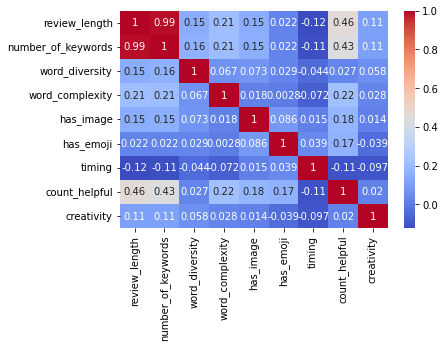

In [9]:
# Check correlation between columns 
correlation_matrix = df_no_NA.corr()

# print the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap = "coolwarm")

plt.show()

In [10]:
"""
Check the effect of dropping the "review length" column, according to my following exploration, I know the only dataset
that works well for all models, with significantly higher accuracy, is the dataframe with missing valure replaced with
min-sd
"""
df_min_minus_sd2 = df_min_minus_sd.drop(columns = ["review_length"])
df_min_minus_sd2

,number_of_keywords,word_diversity,word_complexity,has_image,has_emoji,timing,count_helpful,creativity
0,145,60.161175,7.7,0,0,633,3,72.495699
1,37,62.242682,7.5,1,0,666,0,66.882998
2,46,46.116319,11.4,0,0,652,2,70.648072
3,25,84.124444,11.3,0,0,672,0,52.908236
4,34,66.000000,5.4,0,0,659,0,68.367608
...,...,...,...,...,...,...,...,...
1321,5,0.000000,2.3,0,0,391,0,29.184772
1322,38,76.160000,4.0,1,0,96,36,68.169552
1323,5,7.000000,11.2,0,0,394,0,29.184772
1324,23,43.000000,7.3,0,0,207,1,64.520857


In [11]:
X_no_NA = df_no_NA.iloc[:, :-1]  
y_no_NA = df_no_NA["creativity"]
x_dev_no_NA, x_test_no_NA, y_dev_no_NA, y_test_no_NA = train_test_split(X_no_NA, y_no_NA, test_size=0.2, random_state=0)
x_train_no_NA, x_val_no_NA, y_train_no_NA, y_val_no_NA = train_test_split(x_dev_no_NA, y_dev_no_NA, test_size=0.25, random_state=0)

In [12]:
X_mean = df_replaced_with_mean.iloc[:, :-1]  
y_mean = df_replaced_with_mean["creativity"] 
x_dev_mean, x_test_mean, y_dev_mean, y_test_mean = train_test_split(X_mean, y_mean, test_size=0.2, random_state=0)
x_train_mean, x_val_mean, y_train_mean, y_val_mean = train_test_split(x_dev_mean, y_dev_mean, test_size=0.25, random_state=0)

In [13]:
X_min = df_min_minus_sd.iloc[:, :-1]  
y_min = df_min_minus_sd["creativity"]  
x_dev_min, x_test_min, y_dev_min, y_test_min = train_test_split(X_min, y_min, test_size=0.2, random_state=0)
x_train_min, x_val_min, y_train_min, y_val_min = train_test_split(x_dev_min, y_dev_min, test_size=0.25, random_state=0)

In [14]:
# Add another train test for the set of datasets that have dropped review length
X_min2 = df_min_minus_sd2.iloc[:, :-1]  
y_min2 = df_min_minus_sd2["creativity"]  
x_dev_min2, x_test_min2, y_dev_min2, y_test_min2 = train_test_split(X_min2, y_min2, test_size=0.2, random_state=0)
x_train_min2, x_val_min2, y_train_min2, y_val_min2 = train_test_split(x_dev_min2, y_dev_min2, test_size=0.25, random_state=0)

In [15]:
scalar_s = StandardScaler()
scaler_mm = MinMaxScaler()

In [16]:
# mm_scaler_no_NA = MinMaxScaler()
# mm_scaler_mean = MinMaxScaler()
# mm_scaler_min = MinMaxScaler()

In [17]:
# fit and transform the data
# scaled_data_no_NA = scaler_no_NA.fit_transform(df_no_NA)
# scaled_df_no_NA = pd.DataFrame(scaled_data_no_NA , columns=df.columns)
# scaled_data_mean = scaler_mean.fit_transform(df_replaced_with_mean)
# scaled_df_mean = pd.DataFrame(scaled_data_mean, columns=df.columns)
# scaled_data_min = scaler_min.fit_transform(df_min_minus_sd)
# scaled_df_min = pd.DataFrame(scaled_data_min , columns=df.columns)
x_train_no_NA_s = scalar_s.fit_transform(x_train_no_NA)
x_train_no_NA_mm = scaler_mm.fit_transform(x_train_no_NA)
x_train_mean_s = scalar_s.fit_transform(x_train_mean)
x_train_mean_mm = scaler_mm.fit_transform(x_train_mean)
x_train_min_s = scalar_s.fit_transform(x_train_min)
x_train_min_mm = scaler_mm.fit_transform(x_train_min)

x_val_no_NA_s = scalar_s.transform(x_val_no_NA)
x_val_no_NA_mm = scaler_mm.transform(x_val_no_NA)
x_val_mean_s = scalar_s.transform(x_val_mean)
x_val_mean_mm = scaler_mm.transform(x_val_mean)
x_val_min_s = scalar_s.transform(x_val_min)
x_val_min_mm = scaler_mm.transform(x_val_min)

x_test_no_NA_s = scalar_s.transform(x_test_no_NA)
x_test_no_NA_mm = scaler_mm.transform(x_test_no_NA)
x_test_mean_s = scalar_s.transform(x_test_mean)
x_test_mean_mm = scaler_mm.transform(x_test_mean)
x_test_min_s = scalar_s.transform(x_test_min)
x_test_min_mm = scaler_mm.transform(x_test_min)


In [18]:
# Add another scaling step for the dataset that dropped review length 
x_train_min2_s = scalar_s.fit_transform(x_train_min2)
x_val_min2_s = scalar_s.transform(x_val_min2)
x_test_min2_s = scalar_s.transform(x_test_min2)

In [19]:
# Add a column of ones 
x_train_no_NA_s = np.hstack([np.ones((x_train_no_NA_s.shape[0], 1)), x_train_no_NA_s])
x_val_no_NA_s = np.hstack([np.ones((x_val_no_NA_s.shape[0], 1)), x_val_no_NA_s])
x_test_no_NA_s = np.hstack([np.ones((x_test_no_NA_s.shape[0], 1)), x_test_no_NA_s])

x_train_no_NA_mm = np.hstack([np.ones((x_train_no_NA_mm.shape[0], 1)), x_train_no_NA_mm])
x_val_no_NA_mm = np.hstack([np.ones((x_val_no_NA_mm.shape[0], 1)), x_val_no_NA_mm])
x_test_no_NA_mm = np.hstack([np.ones((x_test_no_NA_mm.shape[0], 1)), x_test_no_NA_mm])

x_train_mean_s = np.hstack([np.ones((x_train_mean_s.shape[0], 1)), x_train_mean_s])
x_val_mean_s = np.hstack([np.ones((x_val_mean_s.shape[0], 1)), x_val_mean_s])
x_test_mean_s = np.hstack([np.ones((x_test_mean_s.shape[0], 1)), x_test_mean_s])

x_train_mean_mm = np.hstack([np.ones((x_train_mean_mm.shape[0], 1)), x_train_mean_mm])
x_val_mean_mm = np.hstack([np.ones((x_val_mean_mm.shape[0], 1)), x_val_mean_mm])
x_test_mean_mm = np.hstack([np.ones((x_test_mean_mm.shape[0], 1)), x_test_mean_mm])

x_train_min_s = np.hstack([np.ones((x_train_min_s.shape[0], 1)), x_train_min_s])
x_val_min_s = np.hstack([np.ones((x_val_min_s.shape[0], 1)), x_val_min_s])
x_test_min_s = np.hstack([np.ones((x_test_min_s.shape[0], 1)), x_test_min_s])

x_train_min_mm = np.hstack([np.ones((x_train_min_mm.shape[0], 1)), x_train_min_mm])
x_val_min_mm = np.hstack([np.ones((x_val_min_mm.shape[0], 1)), x_val_min_mm])
x_test_min_mm = np.hstack([np.ones((x_test_min_mm.shape[0], 1)), x_test_min_mm])

In [20]:
# Add another adding a column of ones step for the dataset that dropped review length 
x_train_min2_s = np.hstack([np.ones((x_train_min2_s.shape[0], 1)), x_train_min2_s])
x_val_min2_s = np.hstack([np.ones((x_val_min2_s.shape[0], 1)), x_val_min2_s])
x_test_min2_s = np.hstack([np.ones((x_test_min2_s.shape[0], 1)), x_test_min2_s])

<font size="10">Model</font>
1. Normal Linear Regression without any parameter adjusted 

In [21]:
lr_no_NA_s = LinearRegression()
lr_mean_s = LinearRegression()
lr_min_s = LinearRegression()
lr_no_NA_mm = LinearRegression()
lr_mean_mm = LinearRegression()
lr_min_mm = LinearRegression()

lr_no_NA_s.fit(x_train_no_NA_s, y_train_no_NA)
lr_mean_s.fit(x_train_mean_s, y_train_mean)
lr_min_s.fit(x_train_min_s, y_train_min)

lr_no_NA_mm.fit(x_train_no_NA_mm, y_train_no_NA)
lr_mean_mm.fit(x_train_mean_mm, y_train_mean)
lr_min_mm.fit(x_train_min_mm, y_train_min)


LinearRegression()

In [22]:
# add another model for dataset that drops review length 
lr_min2_s = LinearRegression()
lr_min2_s.fit(x_train_min2_s, y_train_min2)


LinearRegression()

In [23]:
# mm_lr_no_NA = LinearRegression()
# mm_lr_mean = LinearRegression()
# mm_lr_min = LinearRegression()
# mm_lr_no_NA.fit(mm_x_train_no_NA, mm_y_train_no_NA)
# mm_lr_mean.fit(mm_x_train_mean, mm_y_train_mean)
# mm_lr_min.fit(mm_x_train_min, mm_y_train_min)

In [24]:
print(f"This is the result of linear regression model on the dataset scaled with the Standard Scaler and drop NA")
y_val_pred_no_NA_s = lr_no_NA_s.predict(x_val_no_NA_s)
y_test_pred_no_NA_s = lr_no_NA_s.predict(x_test_no_NA_s)

# calculate the accuracy of the model on the validation and test sets
val_accuracy_r2_no_NA_s = r2_score(y_val_no_NA, y_val_pred_no_NA_s)
test_accuracy_r2_no_NA_s = r2_score(y_test_no_NA, y_test_pred_no_NA_s)

val_accuracy_mse_no_NA_s = mean_squared_error(y_val_no_NA, y_val_pred_no_NA_s)
test_accuracy_mse_no_NA_s = mean_squared_error(y_test_no_NA, y_test_pred_no_NA_s)

# print the accuracy of the model on the validation and test sets
print('r2 Validation accuracy:', val_accuracy_r2_no_NA_s)
print('r2 Test accuracy:', test_accuracy_r2_no_NA_s)
print('mse Validation accuracy:', val_accuracy_mse_no_NA_s)
print('mse Test accuracy:', test_accuracy_mse_no_NA_s)

This is the result of linear regression model on the dataset scaled with the Standard Scaler and drop NA
r2 Validation accuracy: -0.04765814896443388
r2 Test accuracy: 0.03850468044615063
mse Validation accuracy: 49.723250296478426
mse Test accuracy: 46.154215431450346


In [25]:
print(f"This is the result of linear regression model on the dataset scaled with the MinMax Scaler and drop NA")
y_val_pred_no_NA_mm = lr_no_NA_mm.predict(x_val_no_NA_mm)
y_test_pred_no_NA_mm = lr_no_NA_mm.predict(x_test_no_NA_mm)

# calculate the accuracy of the model on the validation and test sets
val_accuracy_r2_no_NA_mm = r2_score(y_val_no_NA, y_val_pred_no_NA_mm)
test_accuracy_r2_no_NA_mm = r2_score(y_test_no_NA, y_test_pred_no_NA_mm)

val_accuracy_mse_no_NA_mm = mean_squared_error(y_val_no_NA, y_val_pred_no_NA_mm)
test_accuracy_mse_no_NA_mm = mean_squared_error(y_test_no_NA, y_test_pred_no_NA_mm)

# print the accuracy of the model on the validation and test sets
print('r2 Validation accuracy:', val_accuracy_r2_no_NA_mm)
print('r2 Test accuracy:', test_accuracy_r2_no_NA_mm)
print('mse Validation accuracy:', val_accuracy_mse_no_NA_mm)
print('mse Test accuracy:', test_accuracy_mse_no_NA_mm)

This is the result of linear regression model on the dataset scaled with the MinMax Scaler and drop NA
r2 Validation accuracy: -0.057664939919615854
r2 Test accuracy: 0.041354932059661564
mse Validation accuracy: 50.198185915335465
mse Test accuracy: 46.0173961206035


In [26]:
print(f"This is the result of linear regression model on the dataset scaled with the Standard Scaler and replace with mean")
y_val_pred_mean_s = lr_mean_s.predict(x_val_mean_s)
y_test_pred_mean_s = lr_mean_s.predict(x_test_mean_s)

# calculate the accuracy of the model on the validation and test sets
val_accuracy_r2_mean_s = r2_score(y_val_mean, y_val_pred_mean_s)
test_accuracy_r2_mean_s = r2_score(y_test_mean, y_test_pred_mean_s)

val_accuracy_mse_mean_s = mean_squared_error(y_val_mean, y_val_pred_mean_s)
test_accuracy_mse_mean_s = mean_squared_error(y_test_mean, y_test_pred_mean_s)

# print the accuracy of the model on the validation and test sets
print('r2 Validation accuracy:', val_accuracy_r2_mean_s)
print('r2 Test accuracy:', test_accuracy_r2_mean_s)
print('mse Validation accuracy:', val_accuracy_mse_mean_s)
print('mse Test accuracy:', test_accuracy_mse_mean_s)

This is the result of linear regression model on the dataset scaled with the Standard Scaler and replace with mean
r2 Validation accuracy: 0.005378983482031807
r2 Test accuracy: -0.042711554053419976
mse Validation accuracy: 35.20429137193299
mse Test accuracy: 44.237544567065406


In [27]:
print(f"This is the result of linear regression model on the dataset scaled with the MinMax Scaler and replace with mean")
y_val_pred_mean_mm = lr_mean_mm.predict(x_val_mean_mm)
y_test_pred_mean_mm = lr_mean_mm.predict(x_test_mean_mm)

# calculate the accuracy of the model on the validation and test sets
val_accuracy_r2_mean_mm = r2_score(y_val_mean, y_val_pred_mean_mm)
test_accuracy_r2_mean_mm = r2_score(y_test_mean, y_test_pred_mean_mm)

val_accuracy_mse_mean_mm = mean_squared_error(y_val_mean, y_val_pred_mean_mm)
test_accuracy_mse_mean_mm = mean_squared_error(y_test_mean, y_test_pred_mean_mm)

# print the accuracy of the model on the validation and test sets
print('r2 Validation accuracy:', val_accuracy_r2_mean_mm)
print('r2 Test accuracy:', test_accuracy_r2_mean_mm)
print('mse Validation accuracy:', val_accuracy_mse_mean_mm)
print('mse Test accuracy:', test_accuracy_mse_mean_mm)

This is the result of linear regression model on the dataset scaled with the MinMax Scaler and replace with mean
r2 Validation accuracy: 0.005378983482031807
r2 Test accuracy: -0.042711554053419976
mse Validation accuracy: 35.20429137193299
mse Test accuracy: 44.237544567065406


In [28]:
print(f"This is the result of linear regression model on the dataset scaled with the Standard Scaler and replace with min - sd")
y_val_pred_min_s = lr_min_s.predict(x_val_min_s)
y_test_pred_min_s = lr_min_s.predict(x_test_min_s)

# calculate the accuracy of the model on the validation and test sets
val_accuracy_r2_min_s = r2_score(y_val_min, y_val_pred_min_s)
test_accuracy_r2_min_s = r2_score(y_test_min, y_test_pred_min_s)

val_accuracy_mse_min_s = mean_squared_error(y_val_min, y_val_pred_min_s)
test_accuracy_mse_min_s = mean_squared_error(y_test_min, y_test_pred_min_s)

# print the accuracy of the model on the validation and test sets
print('r2 Validation accuracy:', val_accuracy_r2_min_s)
print('r2 Test accuracy:', test_accuracy_r2_min_s)
print('mse Validation accuracy:', val_accuracy_mse_min_s)
print('mse Test accuracy:', test_accuracy_mse_min_s)

This is the result of linear regression model on the dataset scaled with the Standard Scaler and replace with min - sd
r2 Validation accuracy: 0.3976504753374863
r2 Test accuracy: 0.40514689317416996
mse Validation accuracy: 216.6242264520308
mse Test accuracy: 212.71832545703697


In [29]:
print(f"This is the result of linear regression model on the dataset scaled with the MinMax Scaler and replace with min - sd")
y_val_pred_min_mm = lr_min_mm.predict(x_val_min_mm)
y_test_pred_min_mm = lr_min_mm.predict(x_test_min_mm)

# calculate the accuracy of the model on the validation and test sets
val_accuracy_r2_min_mm = r2_score(y_val_min, y_val_pred_min_mm)
test_accuracy_r2_min_mm = r2_score(y_test_min, y_test_pred_min_mm)

val_accuracy_mse_min_mm = mean_squared_error(y_val_min, y_val_pred_min_mm)
test_accuracy_mse_min_mm = mean_squared_error(y_test_min, y_test_pred_min_mm)

# print the accuracy of the model on the validation and test sets
print('r2 Validation accuracy:', val_accuracy_r2_min_mm)
print('r2 Test accuracy:', test_accuracy_r2_min_mm)
print('mse Validation accuracy:', val_accuracy_mse_min_mm)
print('mse Test accuracy:', test_accuracy_mse_min_mm)

This is the result of linear regression model on the dataset scaled with the MinMax Scaler and replace with min - sd
r2 Validation accuracy: 0.39765047533748665
r2 Test accuracy: 0.40514689317416996
mse Validation accuracy: 216.62422645203065
mse Test accuracy: 212.71832545703697


In [30]:
# Add another linear regression result for dataset that drops review length 
print(f"This is the result of linear regression model on the dataset scaled with the Standard Scaler and replace with min - sd and also drop the reivew length column")
y_val_pred_min2_s = lr_min2_s.predict(x_val_min2_s)
y_test_pred_min2_s = lr_min2_s.predict(x_test_min2_s)

# calculate the accuracy of the model on the validation and test sets
val_accuracy_r2_min2_s = r2_score(y_val_min2, y_val_pred_min2_s)
test_accuracy_r2_min2_s = r2_score(y_test_min2, y_test_pred_min2_s)

val_accuracy_mse_min2_s = mean_squared_error(y_val_min2, y_val_pred_min2_s)
test_accuracy_mse_min2_s = mean_squared_error(y_test_min2, y_test_pred_min2_s)

# print the accuracy of the model on the validation and test sets
print('r2 Validation accuracy:', val_accuracy_r2_min2_s)
print('r2 Test accuracy:', test_accuracy_r2_min2_s)
print('mse Validation accuracy:', val_accuracy_mse_min2_s)
print('mse Test accuracy:', test_accuracy_mse_min2_s)

This is the result of linear regression model on the dataset scaled with the Standard Scaler and replace with min - sd and also drop the reivew length column
r2 Validation accuracy: 0.377321127201928
r2 Test accuracy: 0.39379555471598626
mse Validation accuracy: 223.93531267992606
mse Test accuracy: 216.77754222973832


<font size = "4.5">For Linear Regression, dropping the review length does not help increase the accuracy but drop slightly </font>

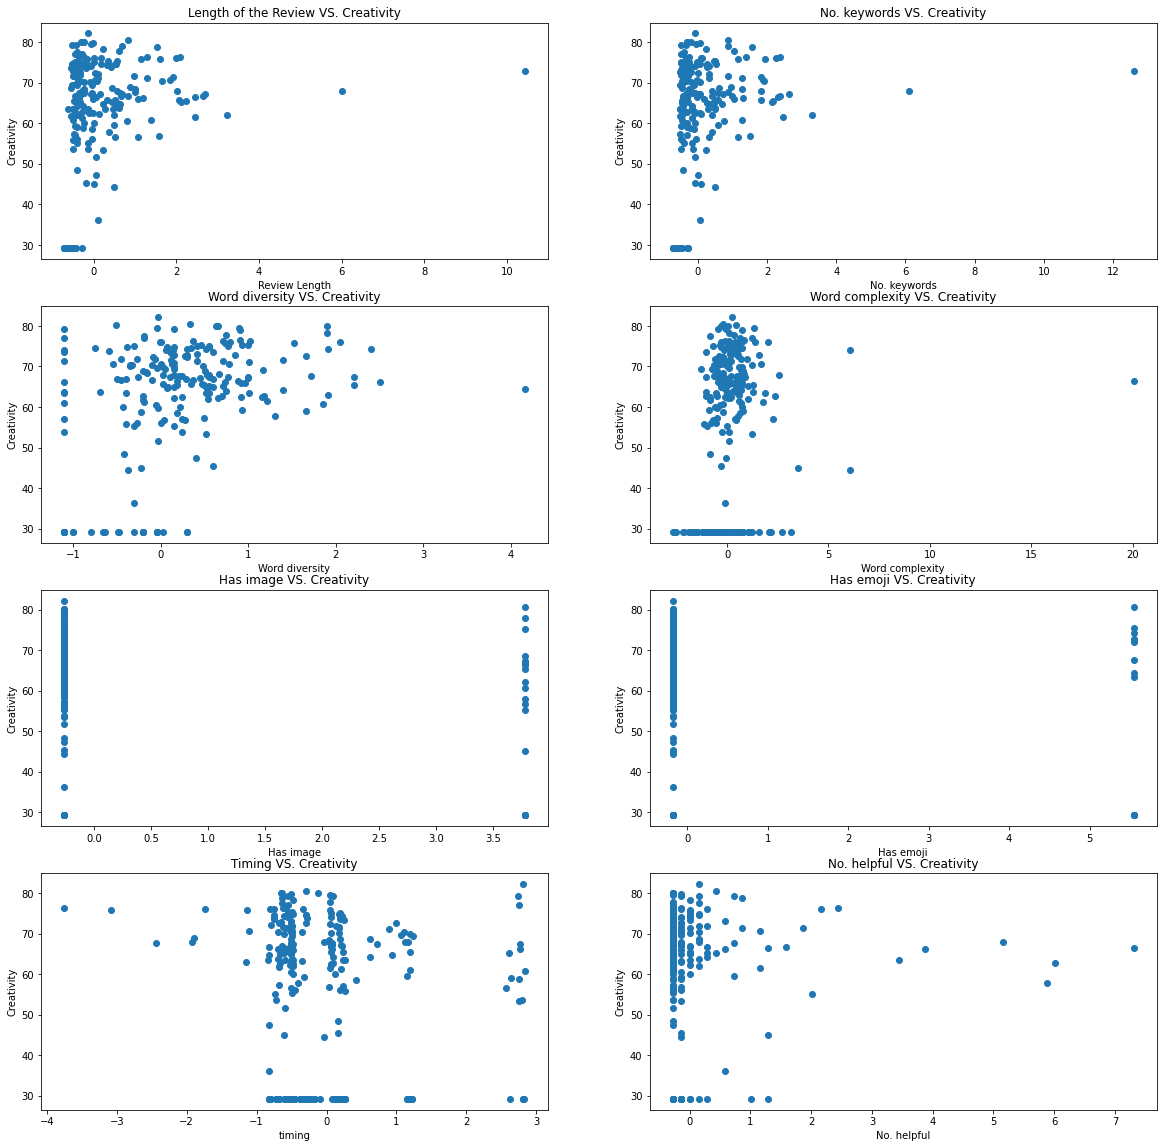

In [31]:
# Plot the relationship between each variable with label in the best dataset we could have 
fig, axs = plt.subplots(4,2, figsize = (20,20))
axs[0,0].scatter(x_test_min_s[:,1], y_test_min)
axs[0,0].set_title("Length of the Review VS. Creativity")
axs[0,0].set_xlabel("Review Length")
axs[0,0].set_ylabel("Creativity")

axs[0,1].scatter(x_test_min_s[:,2], y_test_min)
axs[0,1].set_title("No. keywords VS. Creativity")
axs[0,1].set_xlabel("No. keywords")
axs[0,1].set_ylabel("Creativity")

axs[1,0].scatter(x_test_min_s[:,3], y_test_min)
axs[1,0].set_title("Word diversity VS. Creativity")
axs[1,0].set_xlabel("Word diversity")
axs[1,0].set_ylabel("Creativity")

axs[1,1].scatter(x_test_min_s[:,4], y_test_min)
axs[1,1].set_title("Word complexity VS. Creativity")
axs[1,1].set_xlabel("Word complexity")
axs[1,1].set_ylabel("Creativity")

axs[2,0].scatter(x_test_min_s[:,5], y_test_min)
axs[2,0].set_title("Has image VS. Creativity")
axs[2,0].set_xlabel("Has image")
axs[2,0].set_ylabel("Creativity")

axs[2,1].scatter(x_test_min_s[:,6], y_test_min)
axs[2,1].set_title("Has emoji VS. Creativity")
axs[2,1].set_xlabel("Has emoji")
axs[2,1].set_ylabel("Creativity")

axs[3,0].scatter(x_test_min_s[:,7], y_test_min)
axs[3,0].set_title("Timing VS. Creativity")
axs[3,0].set_xlabel("timing")
axs[3,0].set_ylabel("Creativity")

axs[3,1].scatter(x_test_min_s[:,8], y_test_min)
axs[3,1].set_title("No. helpful VS. Creativity")
axs[3,1].set_xlabel("No. helpful")
axs[3,1].set_ylabel("Creativity")

plt.show()

In [32]:
# Try the Decision tree Regressor 
print(f"This is the accuracy of a normal Decision Tree Regressor with the dataset scaled with Standard Scalaer and missing value replaced with min-sd")
regressor = DecisionTreeRegressor()
regressor.fit(x_train_min_s, y_train_min)

y_val_pred2 = regressor.predict(x_val_min_s)
y_test_pred2 = regressor.predict(x_test_min_s)

# calculate the accuracy of the model on the validation and test sets
val_accuracy_r2_tree = r2_score(y_val_min, y_val_pred2)
test_accuracy_r2_tree = r2_score(y_test_min, y_test_pred2)

val_accuracy_mse_tree = mean_squared_error(y_val_min, y_val_pred2)
test_accuracy_mse_tree = mean_squared_error(y_test_min, y_test_pred2)

# print the accuracy of the model on the validation and test sets
print('r2 Validation accuracy:', val_accuracy_r2_tree)
print('r2 Test accuracy:', test_accuracy_r2_tree)
print('mse Validation accuracy:', val_accuracy_mse_tree)
print('mse Test accuracy:', test_accuracy_mse_tree)

This is the accuracy of a normal Decision Tree Regressor with the dataset scaled with Standard Scalaer and missing value replaced with min-sd
r2 Validation accuracy: 0.583672409351512
r2 Test accuracy: 0.5710940753671438
mse Validation accuracy: 149.72476707007695
mse Test accuracy: 153.3759326791526


/Users/clarencestudy/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


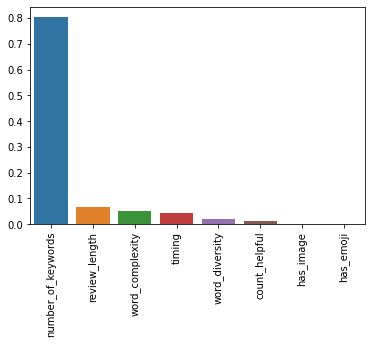

In [33]:
# fetaure importance
feature_importance1 = zip(X_min.columns, regressor.feature_importances_[1:])
features, importances = zip(*(sorted(list(filter(lambda x: x[1]!=0, feature_importance1)), key=lambda x: x[1], reverse=True)))
ax = sns.barplot(list(features), list(importances))
ax.tick_params(axis='x', rotation = 90)
plt.show()

In [34]:
# Try the Decision tree Regressor on the dataset that drops review length
print(f"This is the accuracy of a normal Decision Tree Regressor with the dataset scaled with Standard Scalaer and missing value replaced with min-sd and drop the review length column")
regressor = DecisionTreeRegressor()
regressor.fit(x_train_min2_s, y_train_min2)

y_val_pred2 = regressor.predict(x_val_min2_s)
y_test_pred2 = regressor.predict(x_test_min2_s)

# calculate the accuracy of the model on the validation and test sets
val_accuracy_r2_tree = r2_score(y_val_min2, y_val_pred2)
test_accuracy_r2_tree = r2_score(y_test_min2, y_test_pred2)

val_accuracy_mse_tree = mean_squared_error(y_val_min2, y_val_pred2)
test_accuracy_mse_tree = mean_squared_error(y_test_min2, y_test_pred2)

# print the accuracy of the model on the validation and test sets
print('r2 Validation accuracy:', val_accuracy_r2_tree)
print('r2 Test accuracy:', test_accuracy_r2_tree)
print('mse Validation accuracy:', val_accuracy_mse_tree)
print('mse Test accuracy:', test_accuracy_mse_tree)

This is the accuracy of a normal Decision Tree Regressor with the dataset scaled with Standard Scalaer and missing value replaced with min-sd and drop the review length column
r2 Validation accuracy: 0.5929573663344434
r2 Test accuracy: 0.6027272535601838
mse Validation accuracy: 146.38559846162684
mse Test accuracy: 142.06396907520738


<font size = "4.5">For Decision Tree, dropping the review length does not help increase the accuracy but drop slightly </font>

In [44]:
# Apply Random Forest
print(f"This is result of Random Forest Model without tuning applied on dataset replaced with min-sd and scaled with Standard Scaler")

rf1 = RandomForestRegressor()
rf1.fit(x_train_min_s, y_train_min)
rf1_predict_test1 = rf1.predict(x_test_min_s)

# calculate the accuracy of the model on the validation and test sets
test_accuracy_r2_rf = r2_score(y_test_min, rf1_predict_test1)
test_accuracy_mse_rf = mean_squared_error(y_test_min, rf1_predict_test1)

# print the accuracy of the model on the validation and test sets
print('r2 Test accuracy:', test_accuracy_r2_rf)
print('mse Test accuracy:', test_accuracy_mse_rf)

This is result of Random Forest Model without tuning applied on dataset replaced with min-sd and scaled with Standard Scaler
r2 Test accuracy: 0.7485074648824495
mse Test accuracy: 89.9332462439573


In [45]:
import pickle

# open a file for writing in binary mode
with open('final_model.pickle', 'wb') as file:
    # serialize the object and write it to the file
    pickle.dump(rf1, file)



In [47]:
x_test_min_s[0].shape

(9,)

In [36]:
# Apply Random Forest for the dataset that drops review length
print(f"This is result of Random Forest Model without tuning applied on dataset replaced with min-sd and scaled with Standard Scaler and drop the review length column")

rf1 = RandomForestRegressor()
rf1.fit(x_train_min2_s, y_train_min2)
rf1_predict_test1 = rf1.predict(x_test_min2_s)

# calculate the accuracy of the model on the validation and test sets
test_accuracy_r2_rf = r2_score(y_test_min2, rf1_predict_test1)
test_accuracy_mse_rf = mean_squared_error(y_test_min2, rf1_predict_test1)

# print the accuracy of the model on the validation and test sets
print('r2 Test accuracy:', test_accuracy_r2_rf)
print('mse Test accuracy:', test_accuracy_mse_rf)

This is result of Random Forest Model without tuning applied on dataset replaced with min-sd and scaled with Standard Scaler and drop the review length column
r2 Test accuracy: 0.7197839002654494
mse Test accuracy: 100.20473763632596


<font size = "4.5">For Random Forest, dropping the review length does not help increase the accuracy but drop slightly
so we would still keep the review length column
</font>

In [37]:
# Random Forest Hyperparameter Tuning, let's try tuning with 2 parameters: the number of trees, the depth of the tree 
n_trees = [100, 200, 300, 400, 500, 600]
depth_list = [4,6,8,10,12,14,16,18,20,30,40,50]

# first find what is the optimized number of trees 
tree_scores = []
for n in n_trees:
    rf = RandomForestRegressor(n_estimators = n)
    rf.fit(x_train_min_s, y_train_min)
    scores = cross_val_score(rf, x_val_min_s, y_val_min, cv=10)
    tree_scores.append(np.mean(scores))

tree_scores

[0.7519617845006069,
 0.7519971380904973,
 0.7440592907829622,
 0.7467523978079771,
 0.7506886835328729,
 0.7497636764222573]

In [38]:
depth_scores = []
for d in depth_list:
    rf = RandomForestRegressor(n_estimators = 100, max_depth = d)
    rf.fit(x_train_min_s, y_train_min)
    scores = cross_val_score(rf, x_val_min_s, y_val_min, cv=10)
    depth_scores.append(np.mean(scores))

depth_scores

[0.7460277905399637,
 0.7450350854321401,
 0.743981240025788,
 0.7437922565628196,
 0.7430521988090574,
 0.7439034774544874,
 0.7367110993554229,
 0.7479668327268018,
 0.7439927975932806,
 0.7500990466320567,
 0.7441800207796764,
 0.7410628150338094]

It seems tuning the number of trees does not change significantly on accuracy, 100 trees already give good results. Also tuning through the depth is also not changing accuracy much. In other words, parameter tuning seems not able to change much on the model performance, so it might be worth exploring on data preprocessing part in the future

In [39]:
n_estimators = [10, 20, 30, 40, 50] # The best n_estimator is about 20 
learning_rate = [0.1, 0.2, 0.3, 0.4, 0.5] # The best learning rate is about 0.2 
min_samples_split = list(range(2,30))

# final_score = []
# for i in range(len(n_estimators)):
#     n = n_estimators[i]
#     l = learning_rate[i]
#     m = min_samples_split[i]
#     gb = GradientBoostingRegressor(n_estimators = 20, learning_rate=0.2, min_samples_split=m)
#     gb.fit(x_train_min_s, y_train_min)
#     scores = cross_val_score(gb, x_val_min_s, y_val_min, cv=5)
#     final_score.append(np.mean(scores))
# final_score


final_score = []
for i in range(len(min_samples_split)):
    m = min_samples_split[i]
    gb = GradientBoostingRegressor(n_estimators = 20, learning_rate=0.2, min_samples_split=m)
    gb.fit(x_train_min_s, y_train_min)
    scores = cross_val_score(gb, x_val_min_s, y_val_min, cv=5)
    final_score.append(np.mean(scores))
final_score

[0.678926973431252,
 0.6839864906652202,
 0.705110260008059,
 0.7012631023929309,
 0.696102460879902,
 0.700941665169289,
 0.6996590800408593,
 0.7079477482014391,
 0.709118072866307,
 0.7103997065694861,
 0.7059609494884844,
 0.70820442794335,
 0.7166644462167555,
 0.7126562822013965,
 0.706391911414066,
 0.7095996681777959,
 0.710666984432015,
 0.7051530691506283,
 0.7092356294259471,
 0.7122344152428365,
 0.7118233231285134,
 0.7145173822427371,
 0.7144430612727707,
 0.7188835208268383,
 0.719826016057979,
 0.7200334717070221,
 0.720558629962451,
 0.7218010516192688]

In [40]:
max_leaf_nodes = [100,130,150,170,190]
max_iter = [100,120, 150, 170, 190] # find max iteration is the key hyperparaemter to tune, accuracy saturated around 
final_score = []
for i in range(len(n_estimators)):
    ml = max_leaf_nodes[i]
    mi = max_iter[i]
    hg = HistGradientBoostingRegressor(max_leaf_nodes=m, max_iter=mi)
    hg.fit(x_train_min_s, y_train_min)
    scores = cross_val_score(hg, x_val_min_s, y_val_min, cv=5)
    final_score.append(np.mean(scores))
final_score


# final_score = []
# for i in range(len(min_samples_split)):
#     m = min_samples_split[i]
#     gb = GradientBoostingRegressor(n_estimators = 20, learning_rate=0.2, min_samples_split=m)
#     gb.fit(x_train_min_s, y_train_min)
#     scores = cross_val_score(gb, x_val_min_s, y_val_min, cv=5)
#     final_score.append(np.mean(scores))
# final_score

[0.6986383094871453,
 0.6961844300274451,
 0.6943943247837027,
 0.6962324594704532,
 0.6947184398086877]

In [41]:
[0.7273218411878973,
 0.7258046696002335,
 0.7241295235093446,
 0.7228638204457923,
 0.7213243248395844]

[0.7273218411878973,
 0.7258046696002335,
 0.7241295235093446,
 0.7228638204457923,
 0.7213243248395844]

<font size = "4.5">We have also explored the models of GradientBoostingRegressor and HistGradientBoostingRegressor, both with hyperparameters tuned, and it seems the max they could reach is about 72, which is still slightly less than the performance of Random Forest, so we didn't continue find an finalized optimized set of parameters, since the model itself is suboptimal</font>

In [42]:
from xgboost import XGBRegressor

In [43]:
# n_estimators = [1,3,5,7,10, 50,100, 140, 200] # The best n_estimator is about 10, when it reaches 10, any above doesn't affect much 
# learning_rate = [0.4, 0.6, 0.7, 0.8, 0.9] # The best learning rate is about 0.4, anything above that clearly leads to decrease
max_leaf_nodes = [1,2, 3,4, 5, 10,20, 50, 100, 130,150,170,190, 200, 250] # max leaf seems do not change much when selecting 
final_score = []
for i in range(len(max_leaf_nodes)):
#     n = n_estimators[i]
#     l = learning_rate[i]
    m = max_leaf_nodes[i]
#     xg = XGBRegressor(n_estimators=n, learning_rate=l, max_leaves=m)
    xg = XGBRegressor(n_estimators=10, learning_rate=0.4, max_leaves=m)
    xg.fit(x_train_min_s, y_train_min)
    scores = cross_val_score(xg, x_val_min_s, y_val_min, cv=10)
    final_score.append(np.mean(scores))
max_index = final_score.index(max(final_score))
final_score

# xg1 = XGBClassifier(n_estimators = n_estimators[max_index], learning_rate = learning_rate[max_index], max_leaves = max_leaf_nodes[max_index])
# xg1.fit(X_train, y_train)
# print(f"The test dataset has an accuracy of {accuracy_score(y_test, xg1.predict(X_test))}")

[0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134,
 0.7038698712001134]

<font size = "4.5">Similarly, we have also tested the XGBoost with hyperparameters tuned, and it seems the max they could reach is about 70, less than the performance of Random Forest, so we didn't continue find an finalized optimized set of parameters.</font>